# Experimentos sobre PINNs

En el siguiente cuaderno, se realizaran diferentes experimentos sobre una PINN ajustada al oscilador armónico simple. De esta manera se busca conocer un poco más el funcionamiento y ajuste de estas redes.

## Librerías a usar

In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import numpy as np
import matplotlib.pyplot as plt

## Semillas para reproducir los resultados

In [8]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cuda:0


## Solución exacta

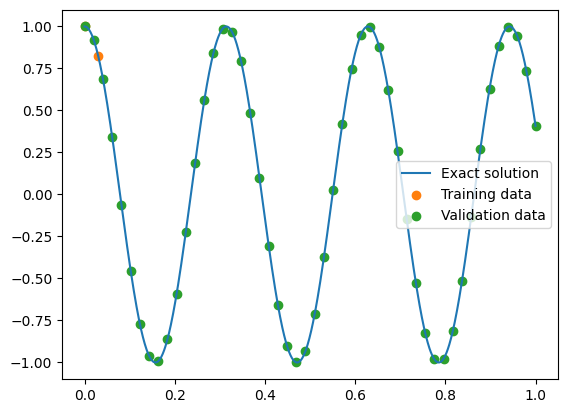

In [3]:
# Exact solution ..................................................................
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y


# We generate the exact solution and the training data ...................
d, w0 = 0., 20.
# get the analytical solution over the full domain ......................
x = torch.linspace(0,1,1000).view(-1,1)

y = oscillator(d, w0, x).view(-1,1)
yn=y

# slice out a small number of points -> training data (2 points here) ..........
x_data = x[0:60:30] # 
y_data = y[0:60:30]


# Definición del conjunto de validación: 200 puntos equidistantes en el dominio [0,1]
x_val = torch.linspace(0,1,50).view(-1,1)
y_val = oscillator(d, w0, x_val).view(-1,1)

# Graficar datos de entrenamiento

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.scatter(x_val, y_val, color="tab:green", label="Validation data")
plt.legend()
plt.show()

# Función para graficar los resultados

def plot_result(x, y, x_data, y_data, yh, xp=None, step=None):
    "Pretty plot training results"
    # Convertir tensores a arrays de NumPy si están en GPU
    if hasattr(x, 'cpu'):
        x = x.cpu().numpy()
    if hasattr(y, 'cpu'):
        y = y.cpu().numpy()
    if hasattr(x_data, 'cpu'):
        x_data = x_data.cpu().numpy()
    if hasattr(y_data, 'cpu'):
        y_data = y_data.cpu().numpy()
    if hasattr(yh, 'cpu'):
        yh = yh.cpu().numpy()
    if xp is not None and hasattr(xp, 'cpu'):
        xp = xp.cpu().numpy()

    plt.figure(figsize=(8,4))
    plt.plot(x, yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(x, y, color="blue", linewidth=2, alpha=0.8, linestyle='--', label="Exact solution")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*np.ones_like(xp), s=30, color="tab:green", alpha=0.4, label='Coloc. points')
    l = plt.legend(loc=(0.72, 0.1), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.32)
    plt.ylim(-1.1, 1.1)
    if step is not None:
        plt.text(0.998, 0.8, "Step: %i" % (step+1), fontsize="xx-large", color="k")
    plt.ylabel('y', fontsize="xx-large")
    plt.xlabel('Time', fontsize="xx-large")
    plt.axis("on")


## PINN

In [4]:
# Normal network ...........................................
class PINN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    
    
model = PINN(1,1,32,3).to(device=device)
print(model)


optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)

PINN(
  (fcs): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
  )
  (fch): Sequential(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
    )
  )
  (fce): Linear(in_features=32, out_features=1, bias=True)
)


c:\Users\anroj\Documents\pinn_astro\PINNs\.venv\Lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iteración 0, Pérdida validación: 0.5112996697425842
Iteración 1000, Pérdida validación: 0.5038890838623047
Iteración 2000, Pérdida validación: 0.922956645488739
Iteración 3000, Pérdida validación: 0.5718789100646973
Iteración 4000, Pérdida validación: 0.0049124304205179214
Iteración 5000, Pérdida validación: 0.0006023191381245852


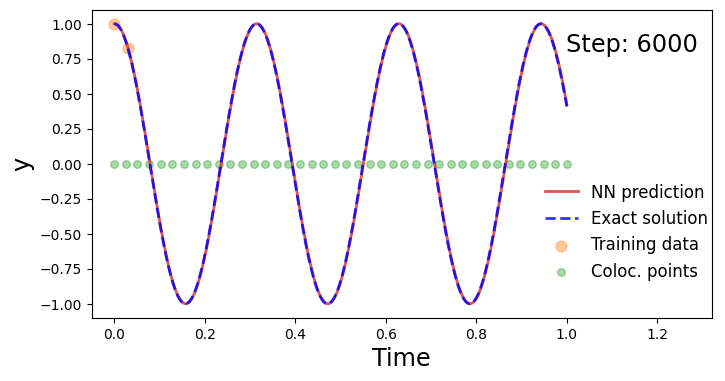

Iteración 6000, Pérdida validación: 9.797434904612601e-05
Iteración 7000, Pérdida validación: 2.2999356588115916e-05
Iteración 8000, Pérdida validación: 6.7103724177286495e-06
Iteración 9000, Pérdida validación: 2.3051691186992684e-06
Iteración 10000, Pérdida validación: 8.747454103286145e-07
Iteración 11000, Pérdida validación: 3.718071468483686e-07


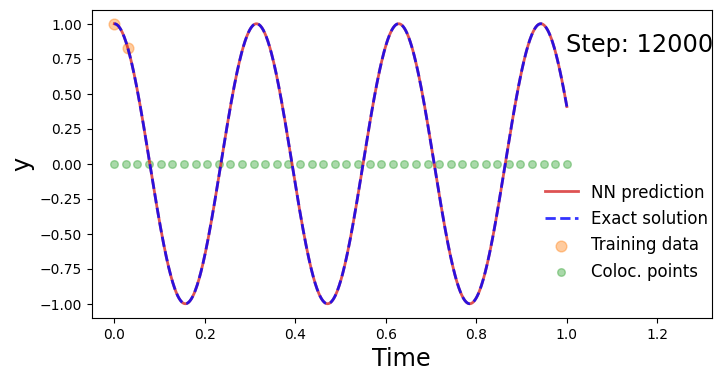

Iteración 12000, Pérdida validación: 2.2587346393265761e-07
Iteración 13000, Pérdida validación: 9.108075715857922e-08
Iteración 14000, Pérdida validación: 4.240777116137906e-07
Iteración 15000, Pérdida validación: 1.0102712622028776e-06
Iteración 16000, Pérdida validación: 2.2703210333929746e-07
Iteración 17000, Pérdida validación: 1.1071104921711594e-08


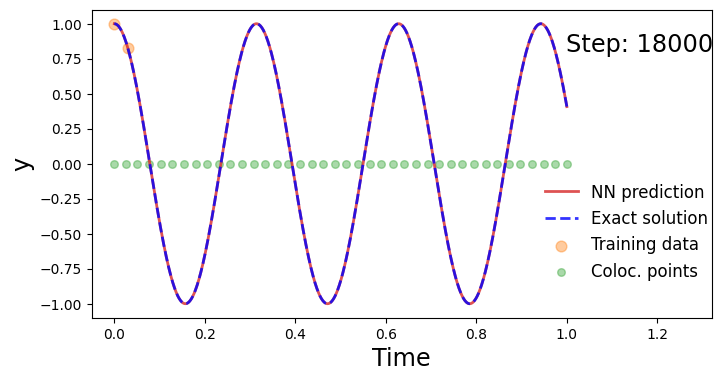

Iteración 18000, Pérdida validación: 7.010364733162078e-09
Iteración 19000, Pérdida validación: 4.677245701856236e-09
Iteración 20000, Pérdida validación: 1.4762821365366108e-06
Iteración 21000, Pérdida validación: 1.0497078619664535e-05
Iteración 22000, Pérdida validación: 7.78334339202047e-08
Iteración 23000, Pérdida validación: 3.315964836048124e-09


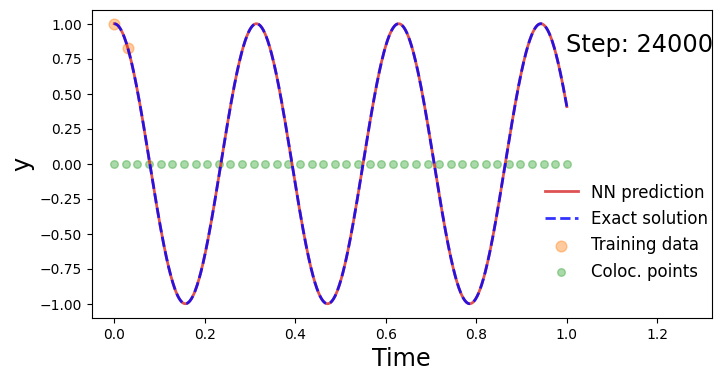

Iteración 24000, Pérdida validación: 1.0033874531245601e-07
Iteración 25000, Pérdida validación: 7.482194178010104e-06
Iteración 26000, Pérdida validación: 3.508862391754519e-07
Iteración 27000, Pérdida validación: 2.952617261797741e-09
Iteración 28000, Pérdida validación: 1.067982768887532e-08
Iteración 29000, Pérdida validación: 3.2982347963894654e-09


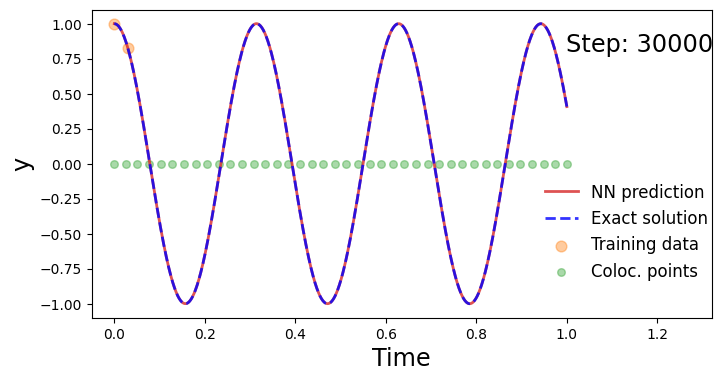

In [ ]:
x = torch.linspace(0,1,1000).view(-1,1).to(device)

y = oscillator(d, w0, x).view(-1,1)
yn=y

x_data = x[0:60:30].to(device) # 
y_data = y[0:60:30]

# Definición del conjunto de validación: 200 puntos equidistantes en el dominio [0,1]
x_val = torch.linspace(0,1,50).view(-1,1).to(device)
y_val = oscillator(d, w0, x_val).view(-1,1)

# We define the collocation points ......................................................................
x_physics = torch.linspace(0,1,40).view(-1,1).requires_grad_(True).to(device)# sample locations over the problem domain
mu, k = 2*d, w0**2

files = []
loss1_history = []
loss2_history = []
loss3_history = []
loss_history = []
mse_history = []

# Entrenamiento: guardar el mejor modelo según la pérdida en validación
best_val_loss = float("inf")
num_epochs = 30000


for i in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # We compute the "data loss" ...................................................................
    yh = model(x_data)
    loss1 = 1.*torch.mean((yh-y_data)**2)# use mean squared error
    
    # We compute the "physics loss"...............................................................
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = (dx2 + mu*dx + k*(yhp))# computes the residual of the harmonic oscillator differential equation
    loss2 = 3.e-4*torch.mean(physics**2)
    
    # We compute the "energy loss" for dy/dt (t=0) =0 ........................................
    physics2 = (dx**2/2. + w0**2*yhp**2/2. - w0**2/2.)
    loss3 = 3.e-4*torch.mean(physics2**2)
    
    yhpp=model(x)
    mse=torch.mean((yhpp-y)**2)
    
    # We backpropagate total loss ..............................
    loss = loss1 + loss2 + loss3     # add loss terms together
    loss.backward()
    optimizer.step()

    # Cada cierta iteración, evaluamos en el conjunto de validación
    if i % 1000 == 0:
        model.eval()
        with torch.no_grad():
            y_val_pred = model(x_val)
            val_loss = torch.mean((y_val_pred - y_val)**2).item()
            print(f"Iteración {i}, Pérdida validación: {val_loss}")
            
            # Guardamos el mejor modelo
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), "mejor_modelo.pth")
        model.train()
       
    # Registro y graficado cada 100 iteraciones 
    if (i + 1) % 100 == 0: 
        loss1_history.append(loss1.detach())
        loss2_history.append(loss2.detach())
        loss3_history.append(loss3.detach())
        loss_history.append(loss.detach())
        mse_history.append(mse.detach())
        
        # Para graficar, se transfieren los tensores a CPU una sola vez
        yh_cpu = model(x).detach().cpu()
        xp_cpu = x_physics.detach().cpu()
        plot_result(x.cpu(), y.cpu(), x_data.cpu(), y_data.cpu(), yh_cpu, xp_cpu, step=i)
        
        if (i + 1) % 6000 == 0: 
            plt.show()
        else: 
            plt.close("all")

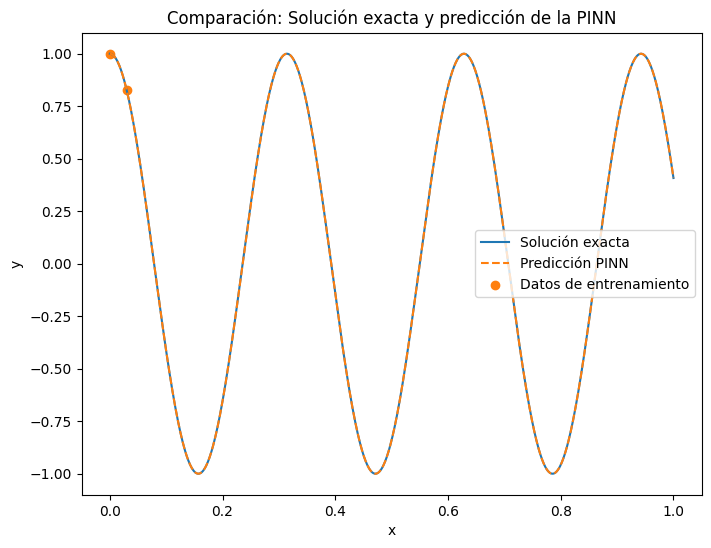

In [9]:
# Cargar el mejor modelo guardado y hacer la predicción en todo el dominio
best_model = PINN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3).to(device)
best_model.load_state_dict(torch.load("mejor_modelo.pth"))
best_model.eval()

with torch.no_grad():
    y_pred = best_model(x)

# Convertir los tensores a CPU para graficar
x_cpu = x.cpu().numpy()
y_cpu = y.cpu().numpy()
y_pred_cpu = y_pred.cpu().numpy()
x_data_cpu = x_data.cpu().numpy()
y_data_cpu = y_data.cpu().numpy()

# Gráfico comparativo: solución exacta vs. predicción de la PINN
plt.figure(figsize=(8, 6))
plt.plot(x_cpu, y_cpu, label="Solución exacta")
plt.plot(x_cpu, y_pred_cpu, '--', label="Predicción PINN")
plt.scatter(x_data_cpu, y_data_cpu, color="tab:orange", label="Datos de entrenamiento")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Comparación: Solución exacta y predicción de la PINN")
plt.show()